In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Make plots look consistent
sns.set_context("talk")

# Output folders
FIG_DIR = "../results/figures"
RES_DIR = "../results"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)


In [2]:

CANDIDATE_PATHS = [
    "../data/processed/analysis_df.csv",
    "../data/processed/analysis_dataset.csv",
    "../data/processed/merged_analysis.csv",
]

data_path = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(
        "Could not find analysis dataset in ../data/processed/. "
        "Update CANDIDATE_PATHS to match your exported filename."
    )

analysis_df = pd.read_csv(data_path)
analysis_df.head(), analysis_df.shape


(  country_code                             country_x  year  \
 0          AFG  {'id': 'AF', 'value': 'Afghanistan'}  2020   
 1          AFG  {'id': 'AF', 'value': 'Afghanistan'}  2017   
 2          AFG  {'id': 'AF', 'value': 'Afghanistan'}  2014   
 3          ALB      {'id': 'AL', 'value': 'Albania'}  2023   
 4          ALB      {'id': 'AL', 'value': 'Albania'}  2022   
 
    female_share_management    country_y  maternity_leave_days  \
 0                    5.889  Afghanistan                  90.0   
 1                    4.255  Afghanistan                  90.0   
 2                    6.928  Afghanistan                  90.0   
 3                   32.382      Albania                 365.0   
 4                   29.107      Albania                 365.0   
 
    paternity_leave_days  shared_parental_leave_days  \
 0                  14.0                         0.0   
 1                  14.0                         0.0   
 2                  14.0                         0.0  

In [3]:
analysis_df.info()

required_cols = ["country_code", "year", "female_share_management", "leave_policy_strength"]
missing = [c for c in required_cols if c not in analysis_df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# Converts types
analysis_df["year"] = pd.to_numeric(analysis_df["year"], errors="coerce")
analysis_df["leave_policy_strength"] = pd.to_numeric(analysis_df["leave_policy_strength"], errors="coerce")
analysis_df["female_share_management"] = pd.to_numeric(analysis_df["female_share_management"], errors="coerce")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country_code                     1650 non-null   object 
 1   country_x                        1650 non-null   object 
 2   year                             1650 non-null   int64  
 3   female_share_management          1650 non-null   float64
 4   country_y                        1650 non-null   object 
 5   maternity_leave_days             1650 non-null   float64
 6   paternity_leave_days             1650 non-null   float64
 7   shared_parental_leave_days       1650 non-null   float64
 8   maternity_leave_days_norm        1650 non-null   float64
 9   paternity_leave_days_norm        1650 non-null   float64
 10  shared_parental_leave_days_norm  1650 non-null   float64
 11  leave_policy_strength            1650 non-null   float64
dtypes: float64(8), int64

In [4]:
model_df = analysis_df.dropna(subset=["female_share_management", "leave_policy_strength", "year"]).copy()

# removes impossible values 
model_df = model_df[(model_df["female_share_management"] >= 0) & (model_df["female_share_management"] <= 100)]

model_df.shape, model_df[["female_share_management","leave_policy_strength","year"]].describe()


((1650, 12),
        female_share_management  leave_policy_strength         year
 count              1650.000000            1650.000000  1650.000000
 mean                 30.633521               0.099903  2013.281818
 std                  10.090034               0.075441     6.581944
 min                   1.194000               0.000000  2000.000000
 25%                  24.160250               0.050645  2008.000000
 50%                  31.367000               0.067999  2014.000000
 75%                  37.366750               0.135282  2019.000000
 max                  74.193000               0.663519  2023.000000)

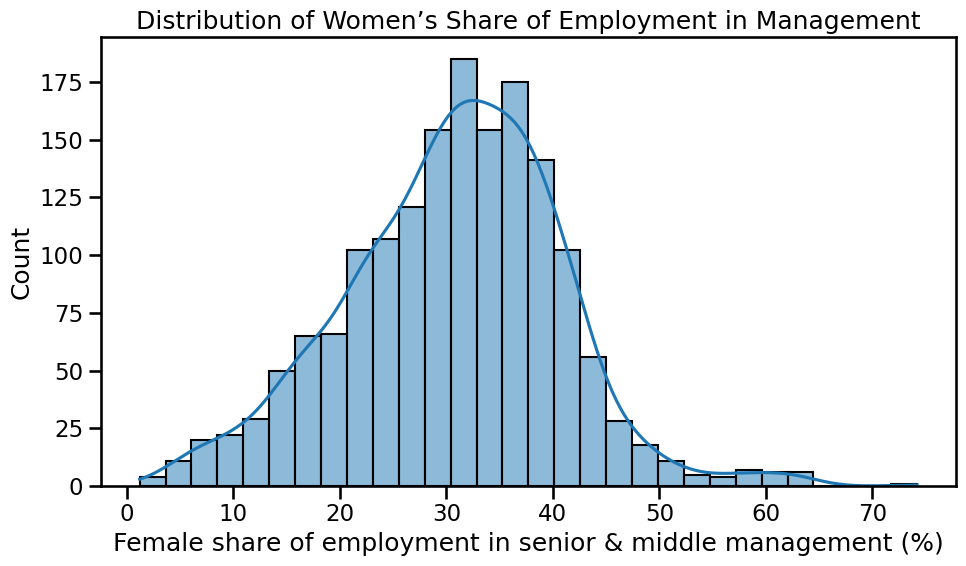

'../results/figures/fig1_dv_distribution.png'

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(model_df["female_share_management"], bins=30, kde=True)
plt.title("Distribution of Women’s Share of Employment in Management")
plt.xlabel("Female share of employment in senior & middle management (%)")
plt.ylabel("Count")
plt.tight_layout()

fig1_path = f"{FIG_DIR}/fig1_dv_distribution.png"
plt.savefig(fig1_path, dpi=300)
plt.show()

fig1_path


(Figure 1). Distribution of women’s share of employment in senior and middle management (%). This plot summarizes the range and central tendency of the dependent variable used in the regression models, helping assess whether values cluster within a narrow band or vary substantially across the sample.

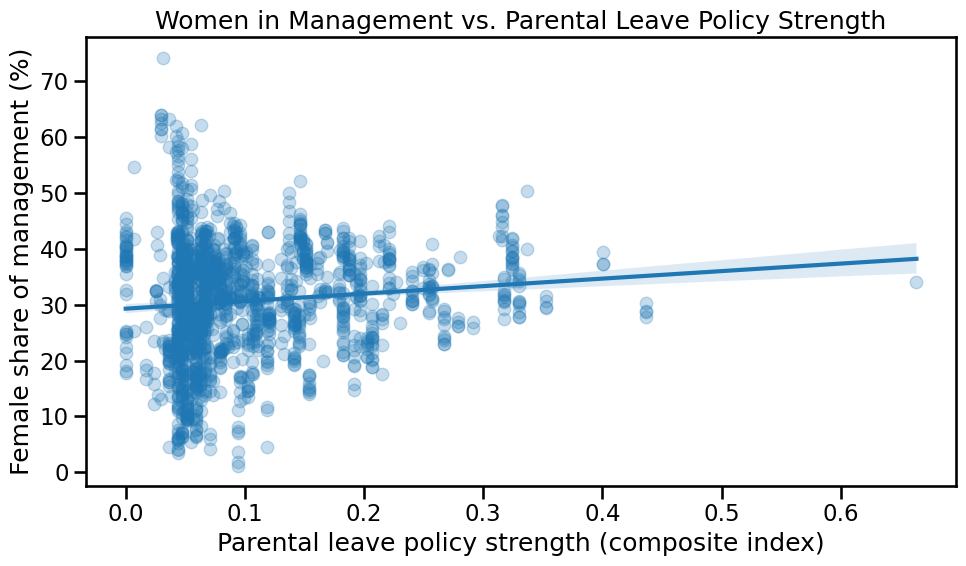

'../results/figures/fig2_scatter_regline.png'

In [6]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=model_df,
    x="leave_policy_strength",
    y="female_share_management",
    scatter_kws={"alpha": 0.25},
    line_kws={"linewidth": 3},
    ci=95
)
plt.title("Women in Management vs. Parental Leave Policy Strength")
plt.xlabel("Parental leave policy strength (composite index)")
plt.ylabel("Female share of management (%)")
plt.tight_layout()

fig2_path = f"{FIG_DIR}/fig2_scatter_regline.png"
plt.savefig(fig2_path, dpi=300)
plt.show()

fig2_path


(Figure 2). Bivariate relationship between parental leave policy strength (composite index) and women’s share of employment in management (%). The fitted line visualizes the average association in the raw data prior to adjusting for time trends or other covariates.

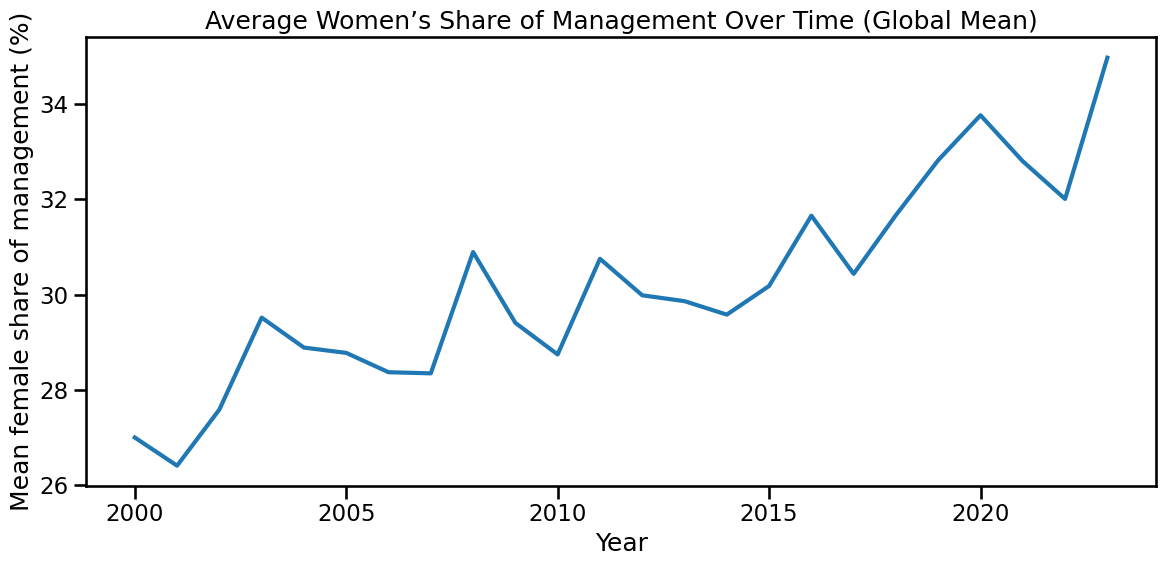

'../results/figures/fig3_time_trend_global_mean.png'

In [7]:
trend = (
    model_df.groupby("year", as_index=False)["female_share_management"]
    .mean()
    .rename(columns={"female_share_management": "mean_female_share_mgmt"})
)

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x="year", y="mean_female_share_mgmt", linewidth=3)
plt.title("Average Women’s Share of Management Over Time (Global Mean)")
plt.xlabel("Year")
plt.ylabel("Mean female share of management (%)")
plt.tight_layout()

fig3_path = f"{FIG_DIR}/fig3_time_trend_global_mean.png"
plt.savefig(fig3_path, dpi=300)
plt.show()

fig3_path


(Figure 3). Average women’s share of employment in management (%) by year, computed as the global mean across available country observations each year. This figure motivates including year controls (fixed effects) by showing whether the dependent variable changes over time independent of policy strength.

In [8]:
def fit_ols(formula, df):
    """
    Fit OLS with heteroskedasticity-robust (HC3) standard errors.
    Returns the fitted model result.
    """
    return smf.ols(formula=formula, data=df).fit(cov_type="HC3")

# Model 0: baseline (intercept only)
m0 = fit_ols("female_share_management ~ 1", model_df)

# Model 1: bivariate association
m1 = fit_ols("female_share_management ~ leave_policy_strength", model_df)

# Model 2: add linear time trend 
m2 = fit_ols("female_share_management ~ leave_policy_strength + year", model_df)

# Model 3: year fixed effects 
m3 = fit_ols("female_share_management ~ leave_policy_strength + C(year)", model_df)

(m0.nobs, m1.nobs, m2.nobs, m3.nobs)


(1650.0, 1650.0, 1650.0, 1650.0)

In [9]:
def tidy_model(result, model_name):
    params = result.params
    se = result.bse
    p = result.pvalues
    out = pd.DataFrame({
        "model": model_name,
        "term": params.index,
        "coef": params.values,
        "std_err_HC3": se.values,
        "p_value": p.values
    })
    out["n"] = int(result.nobs)
    out["r2"] = result.rsquared
    return out

reg_table = pd.concat([
    tidy_model(m0, "Model 0: Intercept only"),
    tidy_model(m1, "Model 1: Policy only"),
    tidy_model(m2, "Model 2: Policy + Year (trend)"),
    tidy_model(m3, "Model 3: Policy + Year FE"),
], ignore_index=True)

reg_table.head(10)


,model,term,coef,std_err_HC3,p_value,n,r2
0,Model 0: Intercept only,Intercept,30.633521,0.248475,0.000000e+00,1650,0.000000
1,Model 1: Policy only,Intercept,29.290563,0.432682,0.000000e+00,1650,0.010102
2,Model 1: Policy only,leave_policy_strength,13.442661,2.670947,4.830683e-07,1650,0.010102
3,Model 2: Policy + Year (trend),Intercept,-527.580335,69.941818,4.588177e-14,1650,0.042655
4,Model 2: Policy + Year (trend),leave_policy_strength,13.550689,2.565726,1.281838e-07,1650,0.042655
5,Model 2: Policy + Year (trend),year,0.276593,0.034752,1.733425e-15,1650,0.042655
6,Model 3: Policy + Year FE,Intercept,25.729308,1.294127,5.874512e-88,1650,0.050450
7,Model 3: Policy + Year FE,C(year)[T.2001],-0.639626,1.915770,7.384744e-01,1650,0.050450
8,Model 3: Policy + Year FE,C(year)[T.2002],0.427139,1.796043,8.120192e-01,1650,0.050450
9,Model 3: Policy + Year FE,C(year)[T.2003],2.404148,1.786460,1.783798e-01,1650,0.050450


In [10]:
table_path = f"{RES_DIR}/regression_tables.csv"
reg_table.to_csv(table_path, index=False)

# A compact comparison table (one row per model)
comparison = pd.DataFrame([
    {"model": "Model 0", "n": int(m0.nobs), "r2": m0.rsquared},
    {"model": "Model 1", "n": int(m1.nobs), "r2": m1.rsquared,
     "policy_coef": m1.params.get("leave_policy_strength", np.nan),
     "policy_p": m1.pvalues.get("leave_policy_strength", np.nan)},
    {"model": "Model 2", "n": int(m2.nobs), "r2": m2.rsquared,
     "policy_coef": m2.params.get("leave_policy_strength", np.nan),
     "policy_p": m2.pvalues.get("leave_policy_strength", np.nan)},
    {"model": "Model 3", "n": int(m3.nobs), "r2": m3.rsquared,
     "policy_coef": m3.params.get("leave_policy_strength", np.nan),
     "policy_p": m3.pvalues.get("leave_policy_strength", np.nan)},
])

comparison_path = f"{RES_DIR}/model_comparison.csv"
comparison.to_csv(comparison_path, index=False)

table_path, comparison_path


('../results/regression_tables.csv', '../results/model_comparison.csv')

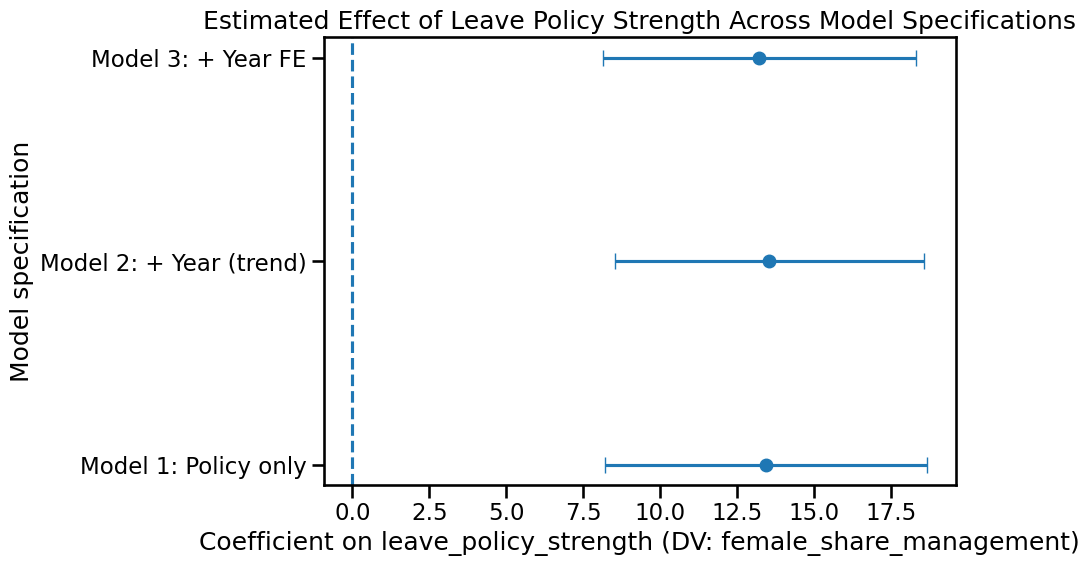

'../results/figures/fig4_policy_coef_plot.png'

In [11]:
# Extracts policy term from models where it exists
def extract_policy_ci(result, label):
    coef = result.params["leave_policy_strength"]
    se = result.bse["leave_policy_strength"]
    # 95% CI using normal approx
    lo = coef - 1.96 * se
    hi = coef + 1.96 * se
    return {"model": label, "coef": coef, "ci_low": lo, "ci_high": hi}

coef_df = pd.DataFrame([
    extract_policy_ci(m1, "Model 1: Policy only"),
    extract_policy_ci(m2, "Model 2: + Year (trend)"),
    extract_policy_ci(m3, "Model 3: + Year FE"),
])

plt.figure(figsize=(10,6))
plt.errorbar(
    x=coef_df["coef"],
    y=coef_df["model"],
    xerr=[coef_df["coef"] - coef_df["ci_low"], coef_df["ci_high"] - coef_df["coef"]],
    fmt="o",
    capsize=6
)
plt.axvline(0, linestyle="--")
plt.title("Estimated Effect of Leave Policy Strength Across Model Specifications")
plt.xlabel("Coefficient on leave_policy_strength (DV: female_share_management)")
plt.ylabel("Model specification")
plt.tight_layout()

fig4_path = f"{FIG_DIR}/fig4_policy_coef_plot.png"
plt.savefig(fig4_path, dpi=300)
plt.show()

fig4_path


(Figure 4). Estimated coefficient for parental leave policy strength across model specifications (with 95% confidence intervals using robust HC3 standard errors). Comparing models demonstrates whether the estimated association is stable after adding time controls (trend and year fixed effects).

In [12]:
outputs = [fig1_path, fig2_path, fig3_path, fig4_path, table_path, comparison_path]
missing = [p for p in outputs if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"Missing expected outputs: {missing}")

print("All Sprint 3 baseline outputs created successfully:")
for p in outputs:
    print(" -", p)


All Sprint 3 baseline outputs created successfully:
 - ../results/figures/fig1_dv_distribution.png
 - ../results/figures/fig2_scatter_regline.png
 - ../results/figures/fig3_time_trend_global_mean.png
 - ../results/figures/fig4_policy_coef_plot.png
 - ../results/regression_tables.csv
 - ../results/model_comparison.csv
